In [1]:
#setup
suppressPackageStartupMessages({
    library(admixtools)                                                  
    library(ape)                                                         
    library(tidyverse)                 
    library(viridis)
})

## 1. estimating admixture proportions
The final task in the F-statistics framework will be to calculate admixture proportions using the $F_4$-ratio. 

For this purpose, we will revisit the world-dataset that we used yesterday. It contains 12 populations throughout the globe. In the Admixture-$F_3$ exercise we found that the Uygurs may be modelled as a mixture of an East-Asian population and a Western Eurasian population. We would now like to estimate the contributions from each population
    ![f4r](F4.large.jpg)

**Task 1**: Use `admixr` (or if you really prefer, qpF4ratio manually) to

- load an eigenstrat object for the world-dataset
- read all populations present in that data into memory using the `read_ind`-function
- have a look at the help by typing `?f4ratio` and comparing it with the tree above
- set up some $F_4$-ratios with appropriate populations to estimate the admixture proportions of the `Uygurs`.
- justify why you are using which population in which position
- what is your estimated admixture proportion?

## 2. Estimating trees

In [2]:
#here we calculate all possible f2 values
f2s = admixtools::f2_from_geno("data/world/world") 

#we arrange them into a matrix
f2_mat = f2(f2s,uni=F) %>%                                           
    arrange(pop1, pop2) %>% select(-se) %>%                          
    pivot_wider(names_from=pop1, values_from=est)                    
f2_mat2= f2_mat %>% column_to_rownames('pop2') %>% as.matrix         

ℹ Reading allele frequencies from packedancestrymap files...
ℹ world.geno has 258 samples and 600841 SNPs
ℹ Calculating allele frequencies from 258 samples in 12 populations
ℹ Expected size of allele frequency data: 125 MB
600k SNPs read...
✔ 600841 SNPs read in total
! 594924 SNPs remain after filtering. 570108 are polymorphic.
ℹ Allele frequency matrix for 594924 SNPs and 12 populations is 100 MB
ℹ Computing pairwise f2 for all SNPs and population pairs requires 2399 MB RAM without splitting
ℹ Computing without splitting since 2399 < 8000 (maxmem)...
ℹ Returning f2 blocks


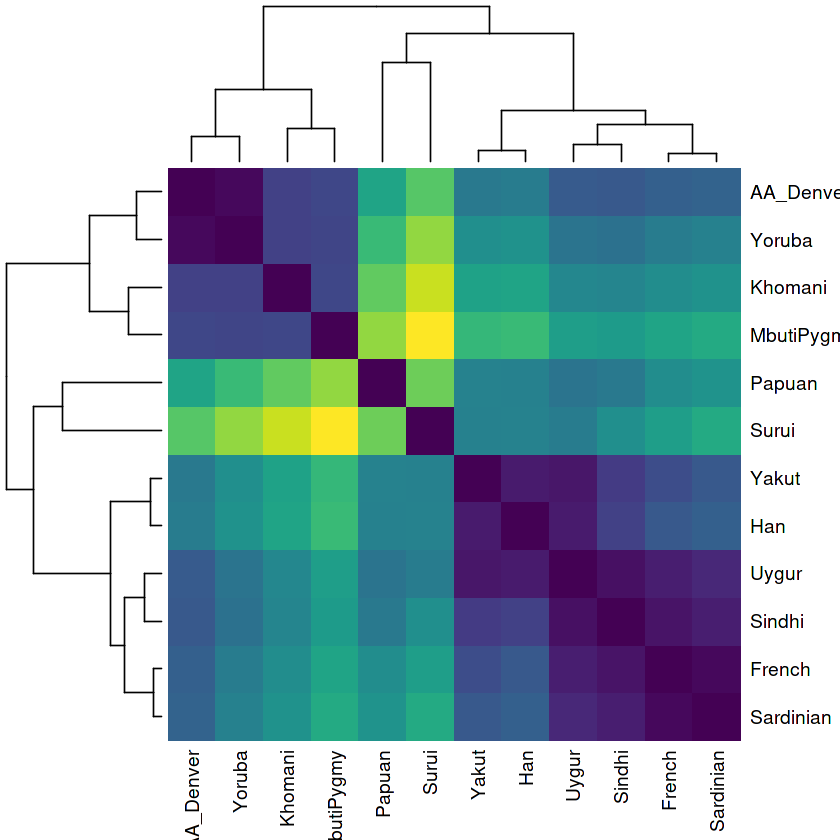

In [3]:
heatmap(f2_mat2, symm=T, scale="none", col=viridis(100))

**Task 2:** Use this data in the `f2_mat2`-data frame to generate a tree using the neighbor joining algorithm.
Use the following functions from the `ape` package:
 
 - `nj()` to calculate the tree
 - `root()` to set an appropriate root
 - `plot.phylo()` to visualize your data

In case you are not sure how these functions work, the help (typing e.g. `?nj` may help)

**Questions:**
   - Can you tell which populations might be admixed?
   - how does that relate to $f_3$-statistics?

## 3. Estimating admixture graphs using qpgraph
Our next task will be to use `qpgraph` to fit a graph. In contrast to `nj`, `qpgraph` does not estimate a graph, so one has to be specified. It will then fit all admixture proportions and branch lengths. One can think of this as obtaining "plausible" graphs that fit the data, without any statements whether they are the best or unique graph for that purpose. Thus, we have to specify a graph. The easiest way is to give it a list using 2 columns, where each row is anedge in the graph.

In [4]:
starting_graph = rbind(                   
              c("ROOT", "MbutiPygmy"),       
              c("ROOT", "AFR"),              
              c("AFR", "AFR1"),           
              c("AFR1", "AA_Denver"),     
              c("AFR", "OOA"),            
              c("OOA", "EUR"),            
              c("OOA", "EAS"),            
              c("EUR", "French"),         
              c("EUR","AA_Denver"),       
              c("EAS", "Han")             
              )                             

For this purpose, we have to define a bunch of internal nodes (a useful convention is to use ALL-CAPS for internal nodes). I.e. in our starting graph, we start at the root, where we us the Mbuti as an outgroup. Within Africa, we have two populations; the African component of the African-American population (AA_Denver), and the out-of-Africa population (OOA). Outside Africa, we split into Europe (EUR) and East Asians (EAS), represented by the French and Han, respectively. Our hypothesis is that the African-Americans have some European ancestry, therefore we add a second edge from `EUR` to `AA_Denver` to reflect that.

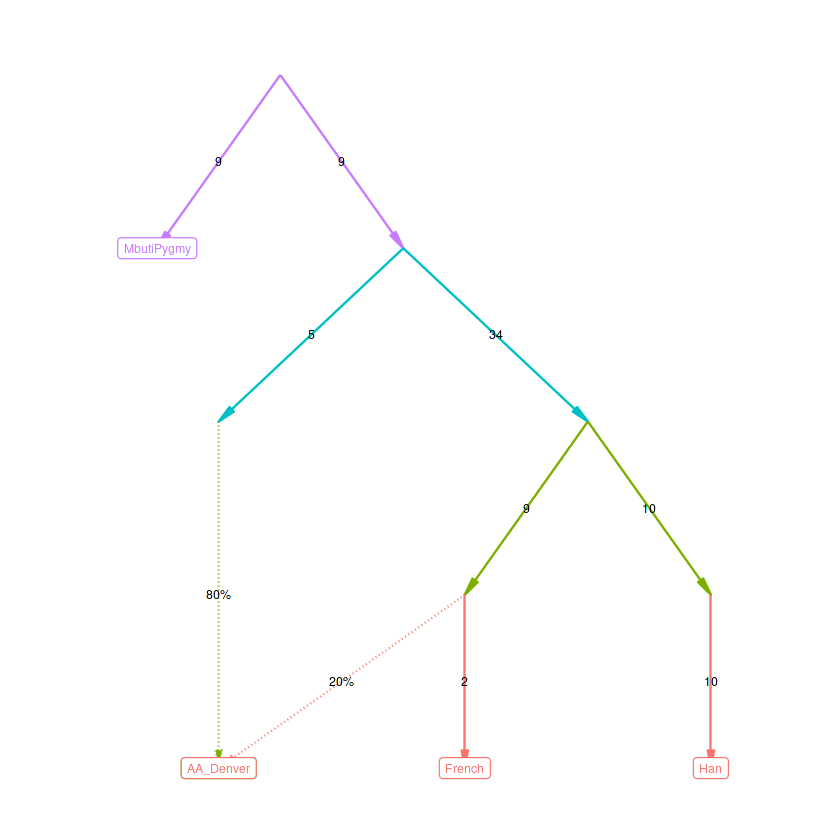

In [5]:
#fitting the graph is done using the qpgraph function:
G = qpgraph(f2s,starting_graph,return_f4=T); 
plot_graph(G$edges)

Next, we can look at the fitted $f_3$ and $f_4$-statistics

In [6]:
G$f3

pop1,pop2,pop3,est,se,fit,diff,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MbutiPygmy,AA_Denver,AA_Denver,0.02320233,0.0002492076,0.02320116,1.166118e-06,0.004679306,0.9962665
MbutiPygmy,AA_Denver,French,0.02693292,0.0002986215,0.02693067,2.250297e-06,0.007535617,0.9939875
MbutiPygmy,AA_Denver,Han,0.02517037,0.0003009477,0.02516889,1.478376e-06,0.004912401,0.9960805
MbutiPygmy,French,French,0.06257204,0.0004294742,0.06256407,7.964443e-06,0.018544638,0.9852044
MbutiPygmy,French,Han,0.05235180,0.0004366679,0.05234331,8.488309e-06,0.019438819,0.9844910
MbutiPygmy,Han,Han,0.07136345,0.0004919125,0.07135530,8.148776e-06,0.016565499,0.9867832


In [7]:
head(G$f4)

pop1,pop2,pop3,pop4,est,se,fit,diff,z,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MbutiPygmy,AA_Denver,MbutiPygmy,AA_Denver,0.023202325,0.0002492076,0.023201159,1.166118e-06,0.004679306,0.9962665
MbutiPygmy,AA_Denver,MbutiPygmy,French,0.026932919,0.0002986215,0.026930669,2.250297e-06,0.007535617,0.9939875
MbutiPygmy,AA_Denver,MbutiPygmy,Han,0.025170370,0.0003009477,0.025168892,1.478376e-06,0.004912401,0.9960805
MbutiPygmy,AA_Denver,AA_Denver,French,0.003730594,0.0001495822,0.003729510,1.084178e-06,0.007248042,0.9942169
MbutiPygmy,AA_Denver,AA_Denver,Han,0.001968045,0.0001634024,0.001967733,3.122573e-07,0.001910972,0.9984753
MbutiPygmy,AA_Denver,French,Han,-0.001762549,0.0001157484,-0.001761777,-7.719212e-07,-0.006668958,0.9946790


the columns
- `est` is the estimated f3/f4-statistic
- `se` is the estimated standard error
- `fit` is the f3/f4-statistic calculated under the model
- `diff` and `z` give the difference `fit-est` and associated Z-score, respectively.

If there are no Z-scores above 3 (or below -3), the model is often considered a fit to the data (again, with no claim about whether it is the best model).

**Task 3:** Assume we want to compare this model where the `AA_Denver`-population only has African Ancestry. For this purpose, remove the edge from `EUR` to `AA_Denver` from the graph. Does this model also fit?

**Task 4:** We picked `French` as a "proxy" for Europeans, and `MbutiPygmy` as a proxy for Africans. What happens if we substitute them for other populations from the same region (e.g. `French -> Sardinian`, `MbutiPygmy -> Yoruba`). What would happen if we add both `French` and `Sardinian` to the model? 

**Task 5:** We would also like to model the `Uygur`-sample in the same admixture graph. Can you add it to the admixture graph in a suitable location? What are the admixture proportions? How do they compare with those estimated using the $f_4$-ratio?